In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os

In [2]:
# --- Step 0: Load the data ---'
save_path = 'C:/Users/anhuy/CS-5806/Project/data/processed' # Make sure this matches

X = pd.read_csv(os.path.join(save_path, 'X_subsampled_trimmed.csv'))
y = pd.read_csv(os.path.join(save_path, 'y_subsampled_trimmed.csv')).squeeze()

lat_lon = pd.read_csv(os.path.join(save_path, 'lat_lon_subsampled_trimmed.csv')).squeeze()

original_index = pd.read_csv(os.path.join(save_path, 'original_index_subsampled_trimmed.csv')).squeeze()

# First split: 70% train, 30% validation + test
X_train, X_temp, y_train, y_temp, latlon_train, latlon_temp, idx_train, idx_temp = train_test_split(
    X, y, lat_lon, original_index, test_size=0.3, random_state=42, shuffle=True)

# Second split: 50% validation, 50% test on the 30% validation + split from the first split (i.e, 15% validation and 15% test in the entire dataset)
X_val, X_test, y_val, y_test, latlon_val, latlon_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, latlon_temp, idx_temp, test_size=0.5, random_state=42, shuffle=True)

In [3]:
# --- Step 1: Define the parameter grid ---
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# --- Step 2: Initialize the model (base model) ---
model = GradientBoostingRegressor(
    subsample=1.0,
    random_state=42
)

# --- Step 3: Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # for regression task
    cv=3,            # 3-fold cross-validation inside training set
    verbose=2,       # show progress
    n_jobs=-1        # use all available CPU cores
)

# --- Step 4: Run the search ---
grid_search.fit(X_train, y_train)

# --- Step 5: Get the best model and parameters ---
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Validation Score (Negative MSE): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# --- Step 6: Evaluate on Validation ---
y_val_pred = best_model.predict(X_val)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Best Validation Score (Negative MSE): -6.8908


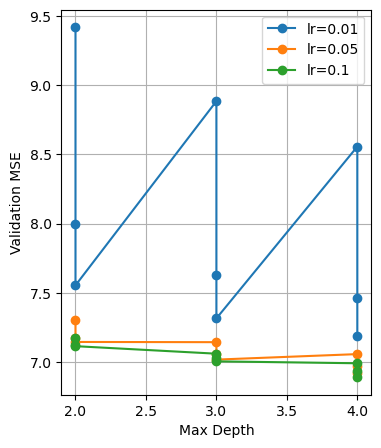

In [4]:
# Extract GridSearchCV results
results = pd.DataFrame(grid_search.cv_results_)

# Plot mean test scores vs max_depth
plt.figure(figsize=(4,5))

for lr in param_grid['learning_rate']:
    subset = results[results['param_learning_rate'] == lr]
    plt.plot(subset['param_max_depth'], -subset['mean_test_score'], marker='o', label=f'lr={lr}')

plt.xlabel('Max Depth')
plt.ylabel('Validation MSE')
# plt.title('Validation MSE vs Max Depth \n for Different Learning Rates')
plt.legend()
plt.grid(True)

# plt.savefig("C:/Users/anhuy/CS-5806/Project/photo/GB_1.png", dpi=300, bbox_inches='tight')

plt.show()

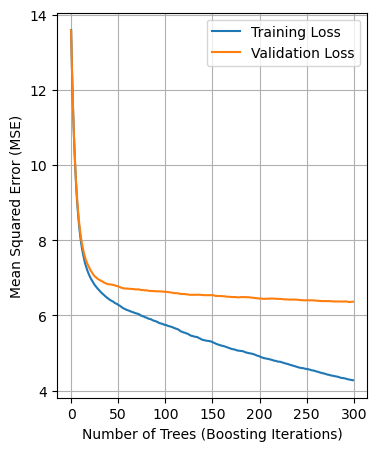

In [5]:
# Lists to store loss at each stage
train_loss = []
val_loss = []

# Training loss
for y_pred_train in best_model.staged_predict(X_train):
    train_loss.append(mean_squared_error(y_train, y_pred_train))

# Validation loss
for y_pred_val in best_model.staged_predict(X_val):
    val_loss.append(mean_squared_error(y_val, y_pred_val))

# Plot the learning curves
plt.figure(figsize=(4,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Trees (Boosting Iterations)')
plt.ylabel('Mean Squared Error (MSE)')
# plt.title('Training and Validation Loss vs Number of Trees')
plt.legend()
plt.grid(True)

# plt.savefig("C:/Users/anhuy/CS-5806/Project/photo/GB_2.png", dpi=300, bbox_inches='tight')

plt.show()

In [6]:
# From the plots above, the best number of trees to prevent overfitting is 150 trees. The best learning rate and max tree depth are 0.1 and 4
best_model_150 = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=150,
    random_state=42
)
best_model_150.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=150, random_state=42)

Test MSE: 6.7324
Test R2: 0.5475


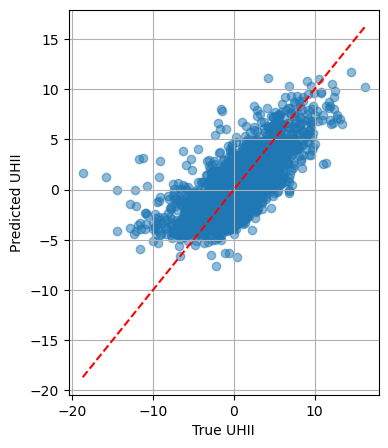

In [7]:
# Predict on the test set
y_test_pred = best_model_150.predict(X_test)

# Evaluate performance on test set
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Test R2: {r2_score(y_test, y_test_pred):.4f}")

# Plot True vs. Predicted
plt.figure(figsize=(4,5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True UHII")
plt.ylabel("Predicted UHII")
# plt.title("True vs Predicted UHII")
plt.grid(True)

# plt.savefig("C:/Users/anhuy/CS-5806/Project/photo/GB_3.png", dpi=300, bbox_inches='tight')

plt.show()